## 0. Required dependencies ##

Same as the 'start_here' file, but ...

### Important note: 

If you want to extract SIFT features, you'll have to have a license for SIFT. If you work with anaconda, this is normally taken care of automatically, but if you are using another environment, you have to install the opencv-contrib-python
package alongside your regular OpenCV installation. Just run 'pip install opencv-contrib-python', or similar, to install it.

If you want to extract SURF features (another great extractor besides SIFT), you'll have to find a version of opencv-python and opencv-contrib-python that still supports SURF (look online).

For more info, check these Stack Overflow questions:
 - https://stackoverflow.com/questions/52305578/sift-cv2-xfeatures2d-sift-create-not-working-even-though-have-contrib-instal
 - https://stackoverflow.com/questions/37039224/attributeerror-module-object-has-no-attribute-xfeatures2d-python-opencv-2
 
It seems some older versions still support SURF. The nice thing is that every other feature extractor here is supported by 4.4.0.46 (the latest version).

In [1]:
# standard packages used to handle files
import sys
import os 
import glob
import time

# commonly used library for data manipulation
import pandas as pd

# numerical
import numpy as np

# handle images - opencv
import cv2

# machine learning library
import sklearn
import sklearn.preprocessing

# used to serialize python objects to disk and load them back to memory
import pickle

# plotting
import matplotlib.pyplot as plt

# helper functions
import helpers

# specific helper functions for feature extraction
import features

# tell matplotlib that we plot in a notebook
%matplotlib notebook

In [2]:
print(cv2.__version__)

4.4.0


In [3]:
# filepath constants, set these according to your workflow:

# where are your datasets:
dataset_path = '../images/'
# where do you want to save your features and other outputs:
output_path = './'

In [4]:
# you don't have to change the paths here:

dataset_path_train = os.path.join(dataset_path, 'train')
dataset_path_test = os.path.join(dataset_path, 'test')

features_path = os.path.join(output_path, 'features')
features_path_train = os.path.join(features_path, 'train')
features_path_test = os.path.join(features_path, 'test')

prediction_path = os.path.join(output_path, 'predictions')

# filepatterns to write out features
filepattern_descriptor_train = os.path.join(features_path_train, 'train_features_{}.pkl')
filepattern_descriptor_test = os.path.join(features_path_test, 'test_features_{}.pkl')

# create paths in case they don't exist:
helpers.createPath(features_path)
helpers.createPath(features_path_train)
helpers.createPath(features_path_test)
helpers.createPath(prediction_path)

## 1. Loading the data and the labels

In [5]:
folder_paths = glob.glob(os.path.join(dataset_path_train, '*'))
label_strings = np.sort(np.array([os.path.basename(path) for path in folder_paths]))
num_classes = label_strings.shape[0]

print("Amount of classes: ", num_classes)
print("\nLabels: \n", label_strings)

Amount of classes:  12

Labels: 
 ['chicken' 'elephant' 'fox' 'german_shepherd' 'golden_retriever' 'horse'
 'jaguar' 'lion' 'owl' 'parrot' 'swan' 'tiger']


In [6]:
train_paths = dict((label_string, helpers.getImgPaths(os.path.join(dataset_path_train, label_string))) 
                   for label_string in label_strings)

test_paths = helpers.getImgPaths(dataset_path_test)

## 2. Extracting features and assembling a simple Bag-Of-Visual-Words model

As a next step, let's extract features from the train and test datasets and save them to disk so we can load them on demand. We will also use some of these features to construct a simple Bag-Of-Visual-Words model [[1]](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=2ahUKEwjVzND0kd7dAhXS2aQKHQDzBVwQFjAAegQICRAC&url=https%3A%2F%2Fwww.cs.cmu.edu%2F~efros%2Fcourses%2FLBMV07%2FPapers%2Fcsurka-eccv-04.pdf&usg=AOvVaw2TCTC70eDULlyc0B7YdCpG)  

As explained in the 'start_here' notebook, a Bag-Of-Visual-Words-Model works according to a similar principle as the classic Bag-of-Words model from Natural Language Processing. Small image patches which represent interesting details of a given image are extracted from the training set. Next, all extracted patches are compared and similarly looking patches are clustered together. This can be done by using a k-means clustering algorithm, which clusters the image patches into k unsupervised categories. It's not necessary to understand exactly how k-means clustering works, but you are encouraged to look it up, since it's a very common and basic unsupervised clustering technique. 

Each of the clusters represents a specific visual characteristic. Since some of the images in our data set contain dogs, we could imagine as an example one cluster representing all samples of dog eyes. Now, whenever we extract a patch from an image that displays a dog eye, our fitted k-means model can assign it to the corresponding cluster.

There will be other types of features besides our hypothetical dog eyes. They can represent many things, like specific stripes, spots, or other patterns. When we extract these patterns for a new (test) image, our pre-fitted k-means clustering algorithm will assign them to the nearest clusters, and we count how many times a certain cluster (= feature) occurs in that image, creating a histogram of features. This histogram will represent the image (and hopefully, the animal) as a whole and can then be used as input to our machine learning models.

If we pass on our histograms to a supervised classifier, it might learn that most of the images containing patches representing cat eyes and patches representing stripes have the label 'tiger'. So we essentially extract higher-level information from low-level images, with the goal of reducing the dimensionality (complexity) for our classifiers. As a side note, a similar reduction is done automatically by the first layers of a (convolutional) neural network. It's where the true power of deep learning lies, in the automatic feature engineering that deep networks do. All layers before the last layer are essentially doing feature engineering, with the last layer doing the actual classification (which is equivalent to a simple logistic regression classifier, but with very good input features that were not engineered by human experts, but by the neural network itself).

Keep in mind though that some of your cluster centers probably represent noisy features, for example picked up from the background of the image. Reducing the amount of clusters can help, but reducing the amount too much might discard relevant features, which are then seen as just one clustered feature. Optimize this for better results. Also, after you've done the clustering, you have a set of workable features, but you can (and probably should) still reduce the dimensionality, or build better features from them. For this, look into topics like dimensionality reduction techniques and feature engineering.

**Important side note:** the dataset consists of images gathered from different sources. This means images have different sizes and resolutions. This influences the amount of feature patches that are found on an image. It might be that low-res images reduce the noise captured from the background, but too low-res might also cause the feature descriptor(s) to not find enough patches, or even any patch (and subsequently, your image becomes impossible to classify). If you find that some classes get worse performance than others, even though you have more images available from that class for training, it might be due to this phenomenon. You can upscale or downscale images easily with OpenCV (before you process them, you could scale every image with just 1 line of code), so this is also something you could finetune. (Another hyperparameter, hooray! Luckily, some manual testing with a few scaling values will get you a decent one quickly and you're set for the rest of the challenge. Only do this when you have finished the other, more important stuff.)

## 3. Detecing Points of interest
We just read that a Bag-Of-Visual-Words (BOVW) works by categorizing extracted image patches which show interesting details of the image. An obvious question is of course: how can an algorithm determine which points of an image are interesting? Many algorithms have been proposed in computer vision, and most of them focus on image regions where large changes can be observed if a small window is slided over the corresponding region. Many of those algorithms are implemented in OpenCV, and we can simply use them as tools without caring too deeply about their inner plumbing. In this tutorial, we will use the Shi-Tomasi corner detector to extract interesting points from images, around which we will extract image patches later. We extract interest points from the first image of every class and plot them into the image.

<IPython.core.display.Javascript object>


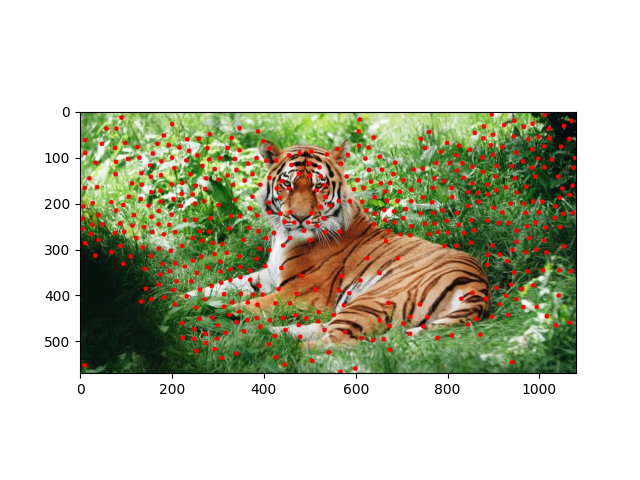

In [10]:
for label_string in label_strings:    
    current_image = cv2.imread(train_paths[label_string][0])
    corner_image, corner_coords = features.extractShiTomasiCorners(
        current_image, num_features=500, min_distance=20, visualize=True
    )    

    plt.imshow(cv2.cvtColor(corner_image, cv2.COLOR_BGR2RGB))
    plt.show()

We can see that the Shi-Tomasi detector mostly catches interesting points on the animals, but for some pictures, there is a lot of background extracted as well. Also, some images have almost no interesting features extracted and will thus be rather hard to classify. For starting out, the performance is acceptable, but let's remember that in the future, if you want to improve the performance of your classifier and you have exhausted all other options, you may want to revisit interest point extraction.

## 4. Good representations for interesting patches
Now that we have some interesting points, we can start clustering. Unfortunately patches of the same object can vary a lot in natural images due to lighting, viewpoint, scale etc. We ideally would like to extract feature vectors from our image patches which make them invariant from the factors above. Falling back on our dog eye example from before, this would mean that image patches showing dog eyes with various illumination, scale etc. still result in very similar features, so they can be clustered correctly into one new feature. Luckily, we do not need to worry about these initial features ourselves, since many of them are again implemented in OpenCV. The most famous and successful among them, namely SIFT [[2]](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwi0hJqPq97dAhVOzaQKHehkDlUQFjAAegQIBBAC&url=https%3A%2F%2Fwww.cs.ubc.ca%2F~lowe%2Fpapers%2Fijcv04.pdf&usg=AOvVaw0cBGKtFZfTh8Vf_Y4kP3LS) has been patented and is thus unfortunately not available in all OpenCV installations (but should be delivered in Anaconda 3). Otherwise, all available feature descriptors will be recomputed from scratch. Browse the [OpenCV documentation](https://docs.opencv.org/3.4.3/index.html) for more point detectors and feature descriptors.

In the start_here notebook, we've been working with only one specific feature extractor, but nothing prohibits you from playing around with the other feature extractors. One particular strategy involving these feature extractors might just dramatically improve your leaderboard score ...

In [10]:
# Add all features which you would like to see computed and their callbacks to this dictionary
# Features where a pickle file already exists will not be recomputed

descriptor_dict = {
    'daisy': features.extractDAISYCallback, # SIFT replacement, very fast, can be computed dense if necessary
    'orb': features.extractORBCallback, # another fast SIFT replacement, oriented BRIEF w. FAST keypoints  
    'freak': features.extractFREAKCallback, # biologically motivated descriptor
    'lucid': features.extractLUCIDCallback,  
    'vgg': features.extractVGGCallback, # Trained as proposed by VGG lab, don't confuse it with VGG-Net features
    'boost_desc': features.extractBoostDescCallback, # Image descriptor learned with boosting
}
                 
if features.checkForSIFT():
    descriptor_dict['sift'] = features.extractSIFTCallback # One descriptor to rule them all

if features.checkForSURF():
    descriptor_dict['surf'] = features.extractSURFCallback # Another very good descriptor

SIFT is unavailable in your current OpenCV install.
SURF is unavailable in your current OpenCV install.


After we have selected all the features we want to extract in the dictionary above, we can proceed by extracting all desired features from the train data and write them to the harddrive using the pickle module.

In [11]:
train_descriptor_dict = descriptor_dict.copy()

# if the corresponding files already exist, do not extract them again
train_descriptor_dict = dict(
    (key, value) for (key, value) in descriptor_dict.items() 
    if not os.path.isfile(filepattern_descriptor_train.format(key))
)

if len(train_descriptor_dict) > 0:
    train_features = []
    train_labels = []
    
    # convert train images
    train_features_by_descriptor = dict((key, []) for (key,value) in train_descriptor_dict.items())
    
    for label_string in label_strings:
        print('Extracting train features for class {} :'.format(label_string))

        extracted_features = features.extractFeatures(train_paths[label_string], train_descriptor_dict, label_string)

        # append descriptors of corresponding label to correct descriptor list 
        for key in train_features_by_descriptor.keys():
            train_features_by_descriptor[key] += extracted_features[key]
  
    for descriptor_key in train_features_by_descriptor.keys():
        with open(filepattern_descriptor_train.format(descriptor_key), 'wb') as pkl_file_train:
            pickle.dump(train_features_by_descriptor[descriptor_key], pkl_file_train, protocol=pickle.HIGHEST_PROTOCOL)

... and the same for the test data set:

In [12]:
test_descriptor_dict = dict(
    (key,value) for (key,value) in descriptor_dict.items() 
    if not os.path.isfile(filepattern_descriptor_test.format(key))
)

if len(test_descriptor_dict) > 0: 
    test_features = []
    
    print('Extracting test features:') 
    
    test_features_by_descriptor = features.extractFeatures(test_paths, test_descriptor_dict, None) 
    
    for descriptor_key in test_features_by_descriptor.keys():
        with open(filepattern_descriptor_test.format(descriptor_key), 'wb') as pkl_file_test:
            pickle.dump(test_features_by_descriptor[descriptor_key], pkl_file_test, protocol=pickle.HIGHEST_PROTOCOL)

Great, if all went well, we should have a significant amount of useful features extracted now. Let's take one of the extracted descriptor and use it to build a bag-of-words train data representation.
The FREAK descriptor serves that purpose as well as any other. We again read and uncompress train and test data descriptors from the harddrive using pickle:

In [13]:
descriptor_desired = 'freak'

In [14]:
with open(filepattern_descriptor_train.format(descriptor_desired), 'rb') as pkl_file_train:
    train_features_from_pkl = pickle.load(pkl_file_train)
    
print(len(train_features_from_pkl))

4042


In [15]:
with open(filepattern_descriptor_test.format(descriptor_desired), 'rb') as pkl_file_test:
    test_features_from_pkl = pickle.load(pkl_file_test)
        
print(len(test_features_from_pkl))

4035


## 5. Constructing a BOVW codebook

Now that we have all our image patches ready, each represented by a FREAK feature vector, we can train a k-means clustering model to cluster these vectors into categories. Do not forget to optimise the number of clusters. This too was implemented in a function in the 'helper' library. Our thanks go out to the authors of [https://github.com/flytxtds/scene-recognition](https://github.com/flytxtds/scene-recognition) where this code has been adapted from.

**Important note:** if you were to encounter an error, similar to 'ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index X has 0 dimension(s)', or: 'ValueError: Expected 2D array, got scalar array instead: array=nan.', this is because your feature descriptor has found no patches on a certain image. If this is in your training set, you can simply remove this image and recreate your features. You can find the image for the former error by printing

    train_features_from_pkl[X] 

(with X the index from your error message), or for the latter error with

    for i, img in enumerate(train_features_from_pkl):
        try:
            _ = len(img.data)
        except ValueError as e:
            print(img)

Let me know what image it was, and I'll update the dataset on Kaggle for the others. It is especially important to let me know if this error occurred in the test set, since otherwise you won't be able to submit a good submission. You can send an e-mail to andries.rosseau@vub.be.

In [16]:
from sklearn.cluster import MiniBatchKMeans
import math

def createCodebook(features, codebook_size=100):    
    # do the clustering using the KMeansTrainer class of OpenCV    
    train_features_to_encode = []
    
    for image_features in features:
        train_features_to_encode.append(image_features.data)

    train_features_to_encode = np.concatenate(train_features_to_encode, axis=0)

    km = MiniBatchKMeans(n_clusters=codebook_size, batch_size=codebook_size * 10)
    start = time.time()
    km.fit(train_features_to_encode)
    end = time.time()
    print('training took {} seconds'.format(end-start))

    return km

In [17]:
codebook_size = 500

km = createCodebook(train_features_from_pkl, codebook_size=codebook_size)

training took 24.089575052261353 seconds


## 6. Encoding Raw image features
Now that we have trained our model we also need a function to encode train and test images. The function below takes all feature vectors extracted from a given image and assigns them to the pretrained categores by predicting their category using the k-means model. Then, the function counts how often the patches of each type occur, and a histogram is constructed using a pandas DataFrame. Finally the vector is normalized by its L2 norm and returned. 

The code fragment below is the function to do this, which is available in the 'helpers' library.


    def encodeImage(features, cluster_model):
        # find the minimal feature distance between all the images
        visual_words = cluster_model.predict(features)
        #print(visual_words)
        word_occurrence = pd.DataFrame(visual_words,columns=['cnt'])['cnt'].value_counts() 
        bovw_vector = np.zeros(cluster_model.n_clusters) 
        for key in word_occurrence.keys():
            bovw_vector[key] = word_occurrence[key]
    
        bovw_feature=bovw_vector/np.linalg.norm(bovw_vector)
        return bovw_feature

This gives us everything we need to build a BOVW represented training dataset, where every image is represented by a normalized histogram which bases its counts on how many image patches of a certain category/cluster/feature were extracted.